<a href="https://colab.research.google.com/github/codingwithac/algorithms-and-data-structures/blob/main/Computer%20Vision/applications/generative%20deep%20learning/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In the following, we implement a variational autoencoder (VAE) that will be able to generate MNIST digits. It will consist of three parts:


1.   an encoder network that encodes a real image into a mean and a variance in the latent space
2.   a sampler layer that takes the mean and variance and uses them to sample a random point from the latent space
3.   a decoder network that decodes points from the latent space back into images



# Encoder Network

The encoder network we will use maps images to the parameters of a probability distribution over the latent space. It is a very simple convnet that maps the input image 'x' to two vectors called 'z_mean' and 'z_log_var'.

Note that we use strides for downsampling the feature maps (instead of max pooling) because we care about information location.

In [2]:
def encoder(latent_dim=2, shape=(28,28,1)):
  # encoder inputs
  inputs = keras.Input(shape=shape)

  # conv layers
  x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", strides=2, padding="same")(inputs)
  x = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", strides=2, padding="same")(x)
  # flatten
  x = keras.layers.Flatten()(x)
  # dense layer
  x = keras.layers.Dense(units=16, activation="relu")(x)
  # encode input image into the mean parameter
  z_mean = keras.layers.Dense(units=latent_dim)(x)
  # encode input image into the variance parameter
  z_log_var = keras.layers.Dense(units=latent_dim)(x)

  # create & return the encoder model
  return keras.Model(inputs=inputs, outputs=[z_mean, z_log_var], name="encoder")

In [3]:
# create the encoder
encoder = encoder()

# print its summary
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

# Sampler Layer

The Sampler layer is used to generate a latent space point called 'z'. As inputs, it gets the parameters of the statistical distribution (z_mean & z_log_var) assumed to have produced the input image.

In [4]:
class Sampler(keras.layers.Layer):
  def call(self, z_mean, z_log_var):
    # set the batch size
    batch_size = tf.shape(z_mean)[0]
    # set the size of the latent space vector
    z_size = tf.shape(z_mean)[1]
    # draw a batch of random normal vector
    epsilon = tf.random.normal(shape=(batch_size, z_size))
    # return vector sampled from the latent space
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder Network

The decoder network maps latent space points to images. It reshapes the sampled vector 'z' to the dimensions of an image and then use a few conv layers to obtain a final image output that has the same dimensions as the original input image.

In [5]:
def decoder(latent_dim=2):
  # inputs
  latent_inputs = keras.Input(shape=(latent_dim, ))

  # dense layer
  x = keras.layers.Dense(units=7*7*64, activation="relu")(latent_inputs)
  # reshape layer
  x = keras.layers.Reshape(target_shape=(7,7,64))(x)
  # Conv2DTranspose layers
  x = keras.layers.Conv2DTranspose(filters=64, kernel_size=3, activation="relu", strides=2, padding="same")(x)
  x = keras.layers.Conv2DTranspose(filters=32, kernel_size=3, activation="relu", strides=2, padding="same")(x)
  # outputs
  decoder_outputs = keras.layers.Conv2D(filters=1, kernel_size=3, activation="sigmoid", padding="same")(x)

  # create & return the decoder model
  return keras.Model(inputs=latent_inputs, outputs=decoder_outputs, name="decoder")


In [6]:
# create the decoder
decoder = decoder()

# print its summary
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

# Variational AutoEncoder (VAE)

We use the encoder, sampling layer and the decoder network to create the variational autoencoder. Note that an autoencoder is an example of self-supervised learning because it uses its inputs as targets.

In [7]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)

    # set the encoder
    self.encoder = encoder
    # set the decoder
    self.decoder = decoder
    # set the sampler
    self.sampler = Sampler()

    # set the trackers for printing the losses
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]


  # implement the train step
  def train_step(self, data):
    with tf.GradientTape() as tape:
      # pass data to the encoder that will encode the inputs into the mean & variance parameters of a distribution
      z_mean, z_log_var = self.encoder(data)
      # draw a latent point using a small random epsilon
      z = self.sampler(z_mean, z_log_var)
      # decode z back to an image
      reconstruction = self.decoder(z)
      # calculate the reconstruction loss
      reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)))
      # calculate the regularization loss using the KL-divergence
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      # add them together
      total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)

    # get the gradients
    grads = tape.gradient(total_loss, self.trainable_weights)
    # optimizer
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # update the state of the losss trackers
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    # print the losses
    return {
        "total_loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

# Train the VAE

In [8]:
# load the MNIST dataset; note that we do not need the labels
(x_train, _), (x_test, _ ) = keras.datasets.mnist.load_data()

# concatenate train & test image datasets
mnist_digits = np.concatenate([x_train, x_test], axis=0)

# normalize the data
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 0s 0us/step


In [9]:
# create the VAE
vae = VAE(encoder, decoder)

# compile the VAE; note that the loss is already part of train_step()
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

# train the model; note that we don't pass targets in fit()
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 272s 495ms/step - total_loss: 213.8242 - reconstruction_loss: 212.1496 - kl_loss: 1.6745
Epoch 2/30
547/547 [==============================] - 259s 474ms/step - total_loss: 187.3393 - reconstruction_loss: 185.1507 - kl_loss: 2.1887
Epoch 3/30
547/547 [==============================] - 268s 490ms/step - total_loss: 182.4853 - reconstruction_loss: 180.2595 - kl_loss: 2.2258
Epoch 4/30
547/547 [==============================] - 266s 486ms/step - total_loss: 178.6645 - reconstruction_loss: 176.2918 - kl_loss: 2.3728
Epoch 5/30
547/547 [==============================] - 265s 485ms/step - total_loss: 175.8298 - reconstruction_loss: 173.3828 - kl_loss: 2.4470
Epoch 6/30
547/547 [==============================] - 263s 482ms/step - total_loss: 174.0289 - reconstruction_loss: 171.5508 - kl_loss: 2.4783
Epoch 7/30
547/547 [==============================] - 263s 480ms/step - total_loss: 172.7457 - reconstruction_loss: 170.2495 - kl_loss: 2.4963

# Visualize

The following code will display a grid of 30x30 digits. First, we sample points linearly on a 2D grid. Then, we iterate over the grid locatins. For each location, we sample a digit and add it to our figure.

1/1 [==============================] - 0s 23ms/step


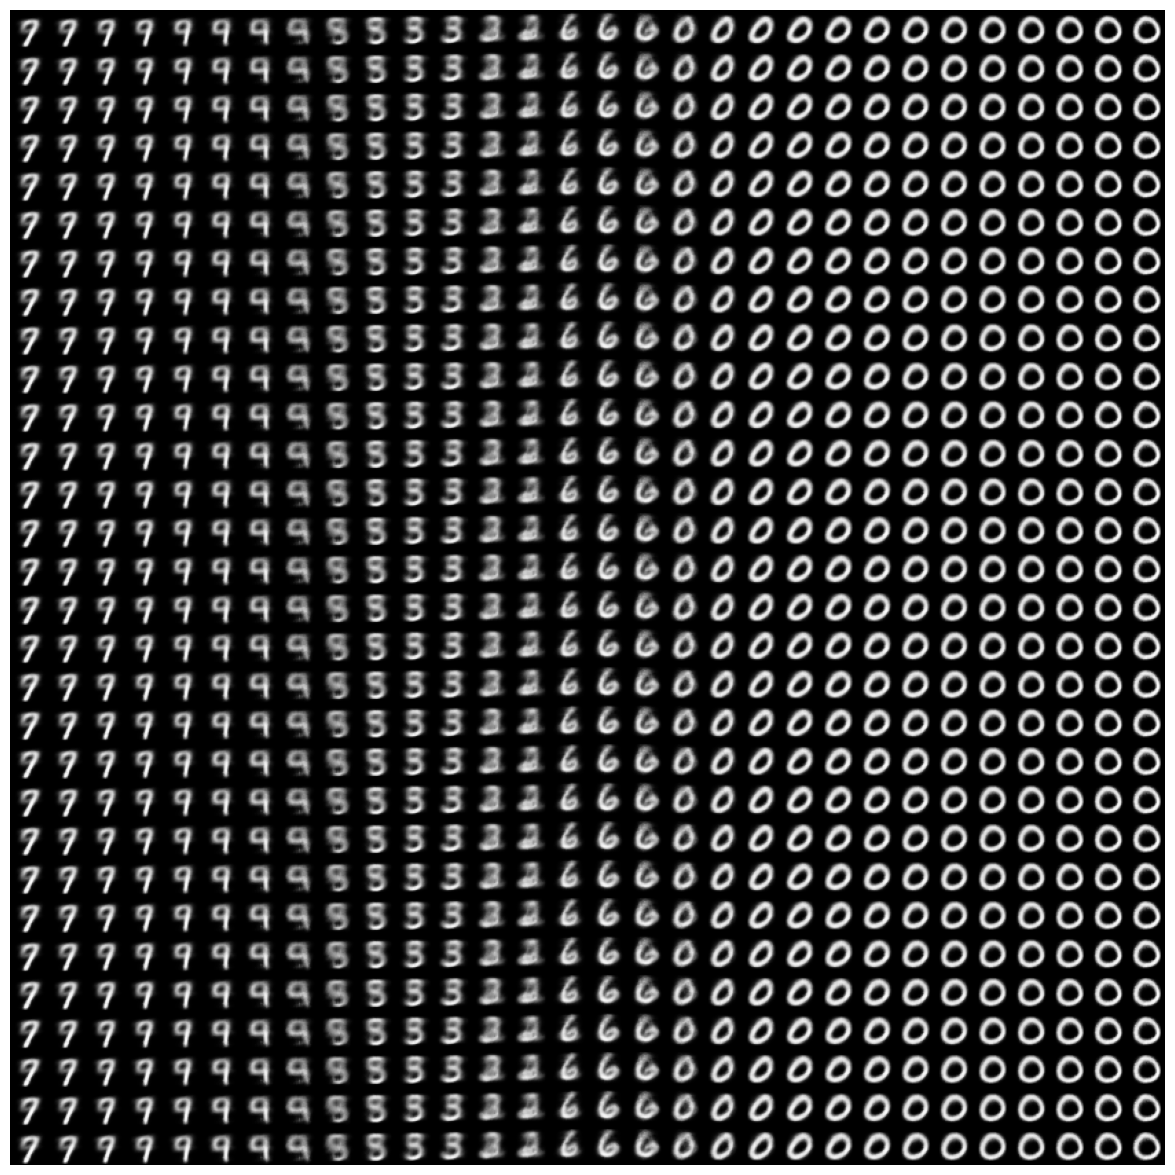

In [11]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")